In [8]:
import csv
import os
import pandas as pd
import numpy as np
from sqlite3 import connect, Error

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [9]:
get_query = """
    SELECT restaurant_orderitem.quantity, restaurant_order.datetime, 
    restaurant_product.name, restaurant_product.price FROM restaurant_orderitem
    INNER JOIN restaurant_order ON restaurant_order.id = restaurant_orderitem.order_id
    INNER JOIN restaurant_product ON restaurant_product.id == restaurant_orderitem.product_id;
"""
db_filename = "db.sqlite3"
csv_filename = "orders_data.csv"

try:
    conn = connect(os.path.join(os.pardir, db_filename))
    with conn:
        cursor = conn.cursor()
        cursor.execute(get_query)
        headers = [col[0] for col in cursor.description]
        data = cursor.fetchall()
except Error as error:
    print(error)

csv_path = os.path.join(os.pardir, csv_filename)
with open(csv_path, "w") as file_writer:
    csvwriter = csv.writer(file_writer)
    csvwriter.writerow(headers)
    csvwriter.writerows(data)


df = pd.read_csv(csv_path)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   quantity  74818 non-null  int64  
 1   datetime  74818 non-null  object 
 2   name      74818 non-null  object 
 3   price     74818 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

<Axes: title={'center': 'Top 10 sold by quantity'}, ylabel='quantity'>

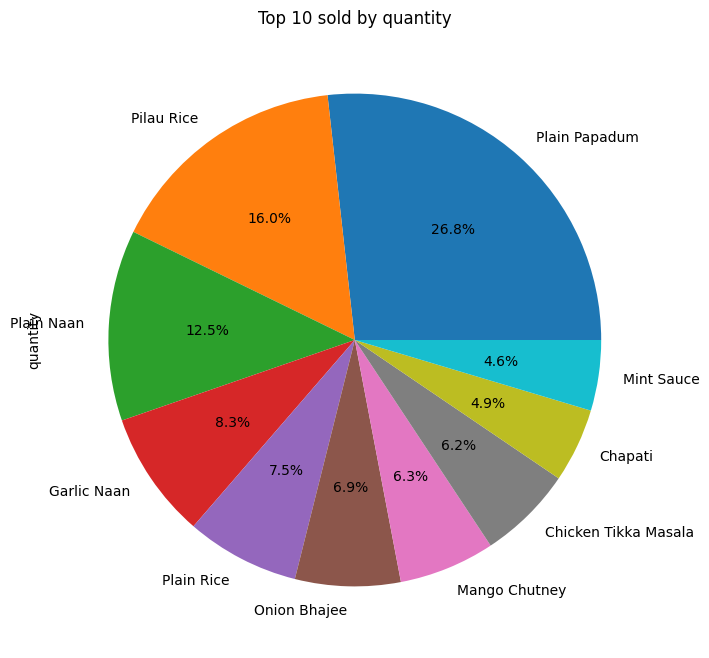

In [10]:
top_popular = (
    df.groupby("name").quantity.sum()
    .sort_values(ascending=False).head(10)
)
top_popular.plot.pie(
    labels=top_popular.index,
    autopct="%1.1f%%",
    title="Top 10 sold by quantity",
    figsize=(8, 8)
)


# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

<Axes: title={'center': 'Top 10 sold by value'}, ylabel='total_price'>

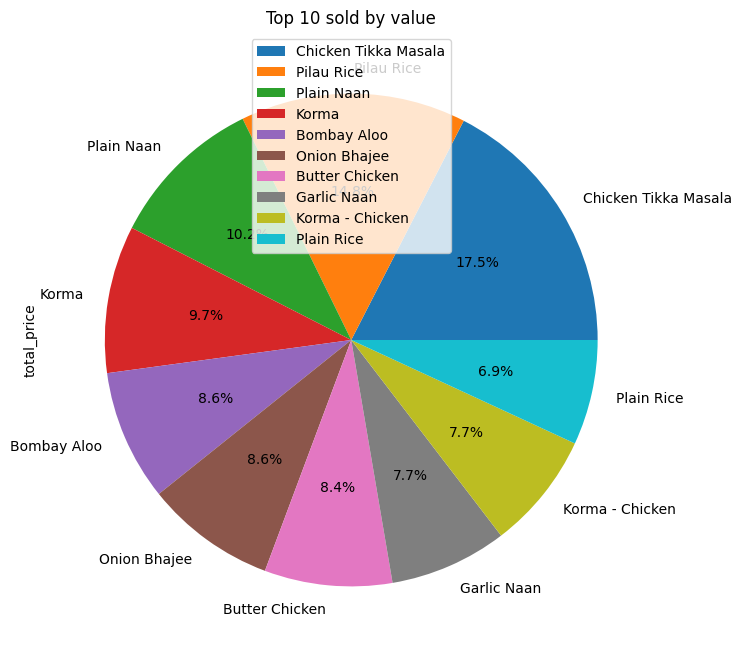

In [11]:
top_by_money = (
    df.assign(total_price=df.quantity*df.price)
    .groupby("name", as_index=False)
    .total_price.sum()
    .sort_values("total_price", ascending=False).head(10)
)
top_by_money.plot.pie(
    y="total_price",
    labels=top_by_money.name,
    autopct="%1.1f%%",
    title="Top 10 sold by value",
    figsize=(8, 8)
)


# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

<Axes: title={'center': 'Profit by order hour'}, xlabel='hour'>

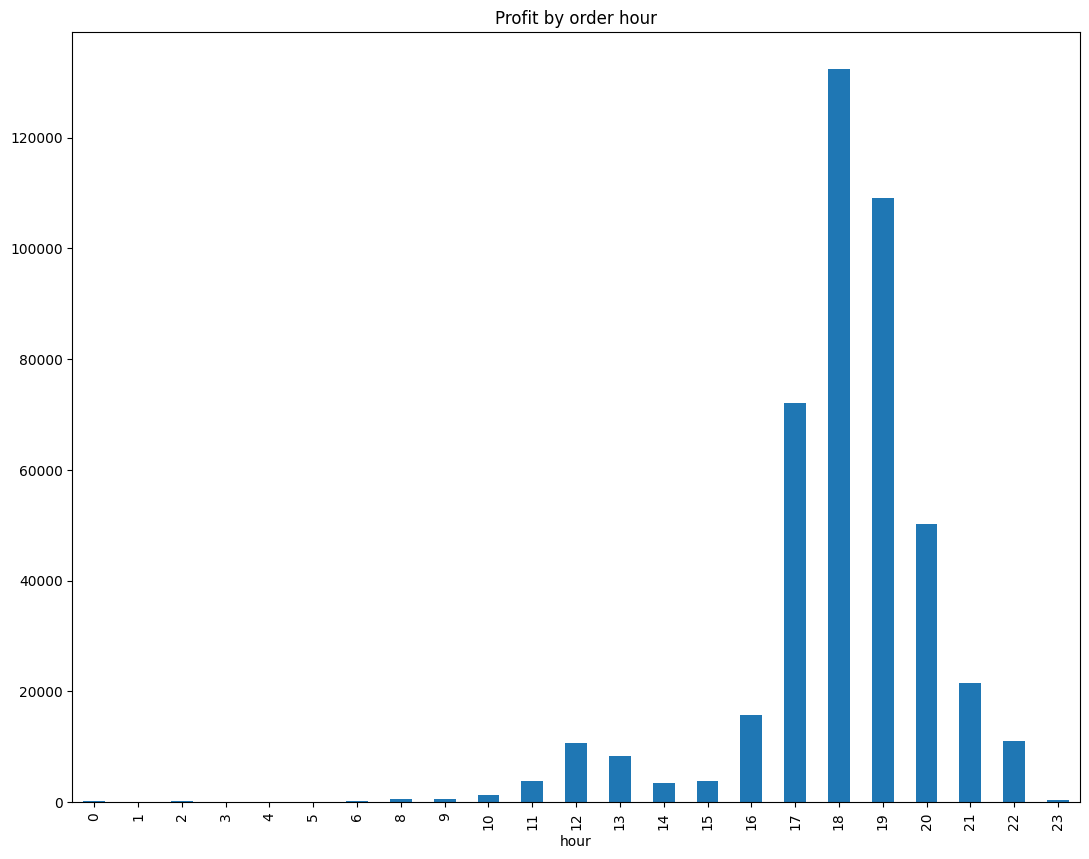

In [12]:
df["datetime"] = df["datetime"].astype("datetime64[ns]")
top_hour = (
    df.assign(order_hour=df.quantity*df.price, hour=df.datetime.dt.hour)
    .groupby("hour").order_hour.sum()
)
top_hour.plot.bar(
    y="order_hour",
    figsize=(13, 10),
    title="Profit by order hour"
)


# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

<Axes: title={'center': 'Profit by order weekday'}, xlabel='day_of_week'>

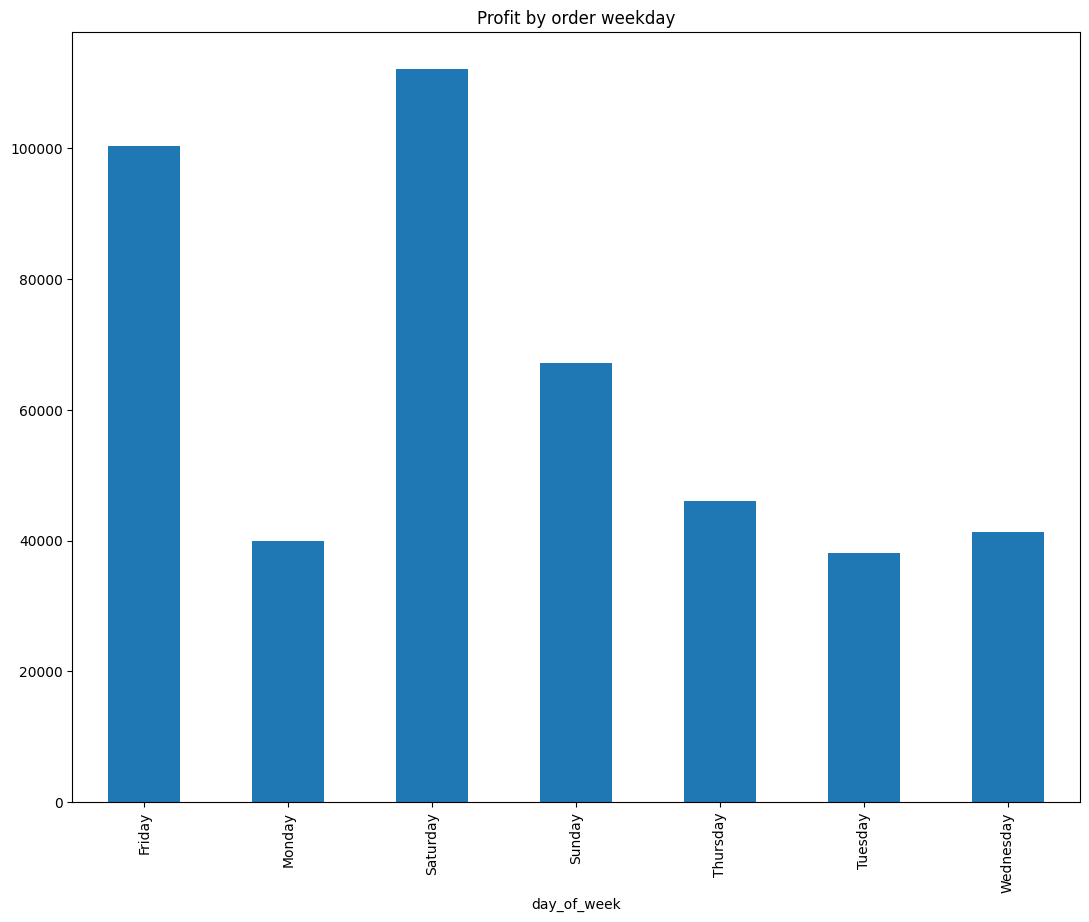

In [13]:
top_weekday = (
    df.assign(
        order_weekday=df.quantity*df.price,
        day_of_week=df.datetime.dt.day_name()
    )
    .groupby("day_of_week").order_weekday.sum()
)
top_weekday.plot.bar(
    y="order_weekday",
    figsize=(13, 10),
    title="Profit by order weekday"
)
